# Цель

Подготовить основу рекомендательной системы курсов в онлайн-школе MasterMind.

# Задачи

1. Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.
2. Обработать данные средствами Python.
3. Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт продакт-менеджеру.
4. Проанализировать результаты A/B-теста, проведённого после внедрения фичи, и сделать вывод.

# Задача 1. Знакомство с данными

У нас в распоряжении две таблицы в Metabase:

- **carts** с данными о пользовательских корзинах (дате создания, статусе, id пользователя-владельца и т. д.);
- **cart items** с данными о курсах, которые пользователи добавили в корзину.

Сначала проведем небольшой первичный анализ данных в Metabase с помощью SQL. По его итогам мы выяснили, что:

- у нас есть данные о продажах за 2017-2018 гг.;
- всего есть 127 различных курсов (но приобретены были 126);
- курсы приобрели 49 006 клиентов;
- в среднем один клиент покупал 1.44 курса;
- 12 656 клиентов купили больше одного курса.

Теперь напишем SQL-запрос, в результате которого получим таблицу с двумя столбцами. В первом столбце будут находиться id пользователей, купивших более одного курса, а во втором столбце - id купленных ими курсов. На этот раз сделаем это уже в Python.


In [1]:
import numpy as np
import pandas as pd
import psycopg2
import psycopg2.extras

# Напишем функцию, которая обращается к базе данных с SQL-запросом и возвращает результат запроса.
def getData():
    query = "WITH course_purchases AS (\
        SELECT ci.id, c.user_id, ci.cart_id, ci.created_at, ci.resource_id, c.promo_code_id, c.purchased_at, c.updated_at\
        FROM final.carts c\
            JOIN final.cart_items ci ON c.id = ci.cart_id\
        WHERE c.state = 'successful' AND ci.resource_type = 'Course'\
         ),\
        users_with_many_courses AS (\
        SELECT user_id, Count(DISTINCT resource_id) courses_count\
        FROM course_purchases\
        GROUP BY 1\
        HAVING Count(DISTINCT resource_id) > 1\
        )\
        SELECT DISTINCT user_id, resource_id\
        FROM course_purchases\
        WHERE user_id IN (SELECT user_id FROM users_with_many_courses)".format()
    conn = psycopg2.connect(dbname='skillfactory',
                            user='skillfactory',
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data

# Преобразуем результат запроса в датафрейм.
df=pd.DataFrame(getData())

In [2]:
# Отсортируем таблицу по id пользователей и приобретенных ими курсов, 
# чтобы потом не получилось зеркальных пар курсов.
df = df.sort_values(by=['user_id','resource_id'], ascending=[True, True], ignore_index=True)
df.head()

,user_id,resource_id
0,51,516
1,51,1099
2,6117,356
3,6117,357
4,6117,1125


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34074 entries, 0 to 34073
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      34074 non-null  int64
 1   resource_id  34074 non-null  int64
dtypes: int64(2)
memory usage: 532.5 KB


# Задача 2. Обработка данных средствами Python

Теперь найдем самые популярные пары курсов. Сделать это придется в несколько этапов.

In [22]:
# Представим полученный выше датафрейм в виде списка кортежей, состоящих из двух элементов.
# Первый элемент - id пользователя, второй элемент - id курса.
df_list = []
for i in range(len(df)):
    df_list.append((df.iloc[i,0],df.iloc[i,1]))
    
# Создадим defaultdict, в котором ключами будут id пользователей, а 
# значениями - id приобретенных ими курсов.
from pprint import pprint
from collections import defaultdict
purchases = defaultdict(list)

for user, course in df_list:
    purchases[user].append(course)

In [5]:
# Убедимся, что длина defaultdict совпадает с количеством
# пользователей, купивших более одного курса.
len(purchases)

12656

In [23]:
# Разобъем каждый набор курсов по парам со всеми возможными комбинациями.
from itertools import combinations
course_pairs_list = []
for course_pack in purchases.values():
    for pair_id in combinations(course_pack,2):
        course_pairs_list.append(pair_id)
        
from collections import Counter
pairs_counter = Counter(course_pairs_list).most_common()

In [7]:
# Узнаем, сколько всего получилось пар курсов.
len(pairs_counter)

3989

Вывод: 

Всего получилось 3989 пар курсов. Самая популярная пара (551, 566) встречается 797 раз.

# Задача 3. Составить итоговую таблицу с рекомендациями

Итоговая таблица должна состоять из трёх столбцов:

1. Курс, к которому идёт рекомендация.
2. Курс для рекомендации № 1 (самый популярный).
3. Курс для рекомендации № 2 (второй по популярности).

In [8]:
# Сначала преобразуем полученный ранее счетчик в датафрейм.
course_pairs_df = pd.DataFrame(pairs_counter)
course_pairs_df.columns = ['course_pairs','frequency']
course_pairs_df.head(100)

,course_pairs,frequency
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290
...,...,...
95,"(515, 794)",66
96,"(504, 566)",66
97,"(840, 1161)",65
98,"(489, 809)",65


Теперь нужно определить минимальную границу - насколько часто должна встречаться пара курсов, чтобы ее можно было использовать в рекомендательной системе.

In [9]:
# Проанализируем значения столбца frequency, в котором указано, 
# как часто встречались пары курсов.
course_pairs_df['frequency'].describe()

count    3989.000000
mean       10.031838
std        26.355998
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       797.000000
Name: frequency, dtype: float64

In [10]:
print(course_pairs_df['frequency'].quantile(0.8))
print(course_pairs_df['frequency'].quantile(0.9))

11.0
22.0


Ранее мы узнали, что всего у нас встречаются 3989 разных пар курсов, а самую популярную пару покупали 797 раз. Теперь описательная статистика показала, что в среднем одну пару курсов покупают около 10 раз. Однако большинство пар курсов встречались слишком редко. Так, 25% пар покупали только один раз, половину пар - не более 3 раз, а 75% пар - не более 9 раз. Также я посчитал 80-й и 90-й процентили. Оказалось, что 80% пар курсов покупали не более 11 раз, а 90% пар - не более 22 раз. Таким образом, в ТОП-10% самых популярных пар находятся те, которые встретились более 22 раз.

Ниже изображена частота покупок пар курсов на графике. Поскольку пар курсов слишком много (3989) и они расположены в порядке убывания частотности, вместо столбчатой диаграммы я построил линейную.

Кроме того, нужно учитывать, что всего у нас 127 различных курсов. Некоторые курсы могут часто попадать в ТОП самых популярных пар. Если слишком ужесточить критерий отбора, есть риск, что часто рекомендательная система будет предлагать пользователям дополнительно приобрести не те курсы, которые встречались в реальных парах, а просто популярные курсы, даже если они не отвечают интересам пользователя.

Сначала я хотел установить минимальную границу на уровне 22 раз (90-й процентиль). Однако в этом случае даже первую рекомендацию удалось подобрать только для 84 курсов, а вторую - для 71. На мой взгляд, это слишком мало, так как примерно треть курсов не имели бы хотя бы одной "реальной" рекомендации. Поэтому затем я проверил минимальную границу на уровне 11 раз (80-й процентиль). В этом случае первую рекомендацию удалось подобрать для 101 курса, а вторую - только для 93. Такой критерий мне тоже показался слишком строгим. Постепенно снижая строгость критерия, я решил остановиться на медиане. Так удалось подобрать первую рекомендацию для 115 курсов, а вторую - для 113. Соответственно, ***для рекомендательной системы будем брать пары, которые встречались чаще 3 раз***. В конце концов, снижение минимальной границы не влияет на рекомендации для наиболее популярных курсов, зато может повысить точность рекомендаций и, соответственно, дополнительные продажи при выборе пользователем малополулярных курсов. 

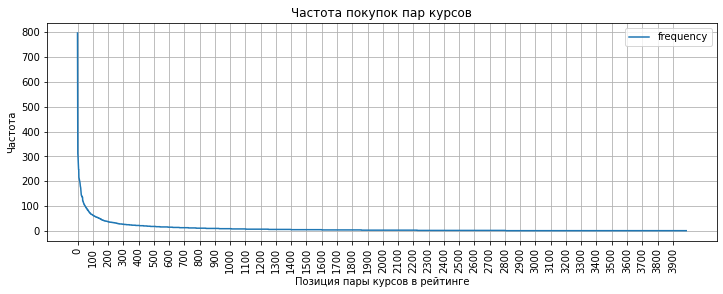

In [11]:
# Поскольку пар курсов слишком много (3989), вместо столбчатой диаграммы построим линейную.
course_pairs_df.plot(
    kind='line',
    y='frequency',
    grid=True,
    xticks=range(0,4000,100),
    rot=90,
    title='Частота покупок пар курсов',
    xlabel='Позиция пары курсов в рейтинге',
    ylabel='Частота',
    figsize=(12, 4)
);

In [12]:
min_limit = course_pairs_df['frequency'].quantile(0.5)
print(min_limit)

3.0


Теперь приступим к созданию итоговой таблицы.

In [13]:
# Сначала создадим список с id курсов.
courses_list = []
for course in df['resource_id']:
    if course not in courses_list:
        courses_list.append(course)
        
courses_list = sorted(courses_list)

len(courses_list)

126

В списке 126 элементов, потому что именно такое количество курсов было приобретено.

Теперь напишем функцию, которая будет для каждого из этих курсов искать по две наиболее подходящие рекомендации.

In [14]:
# Сначала для удобства превратим созданный ранее счетчик в словарь.
pairs_frequency_dict = dict(pairs_counter)

# Функция будет выглядеть следующим образом.
def recommend_course(main_course_id):
    recommendations_list = []
    for pair in pairs_frequency_dict.keys():
        # Если id курса встречается в паре на первом месте и частотность выше минимальной границы, 
        # добавляем пару курсов в список рекомендаций.
        if (pair[0] == main_course_id) and (pairs_frequency_dict[pair] > min_limit):
            recommendations_list.append((pair, pairs_frequency_dict[pair]))
        # Если id курса встречается в паре на втором месте и частотность выше минимальной границы, 
        # добавляем пару курсов в список рекомендаций.
        elif (pair[1] == main_course_id) and (pairs_frequency_dict[pair] > min_limit):
            recommendations_list.append((pair, pairs_frequency_dict[pair]))
        # Отсортируем полученный список по частотности пар
        recommedations_list = sorted(recommendations_list, key=lambda x: x[1], reverse=True)
    # Вернем только две пары наиболее подходящие пары. 
    return recommendations_list[:2]

In [15]:
# Теперь применим эту функцию к списку курсов.
all_recommendations = []
for main_course in courses_list:
    recommendations = recommend_course(main_course)
    all_recommendations.append(recommendations)

print(all_recommendations)

[[((356, 571), 103), ((356, 357), 100)], [((357, 571), 112), ((356, 357), 100)], [((358, 570), 25), ((358, 752), 19)], [((359, 570), 16), ((358, 359), 15)], [((360, 745), 17), ((360, 516), 12)], [((361, 551), 49), ((361, 1138), 40)], [((362, 363), 18), ((362, 562), 8)], [((363, 511), 99), ((363, 562), 77)], [((364, 551), 6), ((364, 503), 5)], [((365, 551), 4)], [((366, 551), 63), ((366, 515), 45)], [((367, 551), 46), ((367, 515), 38)], [((368, 572), 29), ((368, 569), 27)], [((489, 551), 311), ((489, 515), 286)], [((490, 566), 253), ((490, 551), 247)], [((502, 551), 135), ((502, 566), 120)], [((503, 551), 60), ((503, 513), 55)], [((504, 572), 184), ((504, 569), 139)], [((507, 570), 172), ((507, 752), 150)], [((507, 508), 61), ((508, 570), 54)], [((509, 745), 59), ((509, 553), 48)], [((363, 511), 99), ((511, 562), 55)], [((503, 513), 55), ((513, 551), 38)], [((514, 551), 200), ((514, 515), 139)], [((515, 551), 417), ((489, 515), 286)], [((516, 745), 199), ((516, 553), 107)], [((517, 551)

Наконец, приступим к созданию самой итоговой таблицы.

In [16]:
recommendations_df = pd.DataFrame(columns=['main_course', 'recommendation_1','recommendation_2'])

# C помощью цикла заполним значения столбцов.
for i in range(len(courses_list)):
    # Если к курсу удалось подобрать две рекомендации, сделаем это следующим образом.
    if len(all_recommendations[i]) == 2:
        # Если основной курс в обеих рекомендуемых парах был на первом месте, добавим курсы со вторых мест.
        if (courses_list[i] == all_recommendations[i][0][0][0]) and (courses_list[i] == all_recommendations[i][1][0][0]):
            recommendations_df.loc[i] = [courses_list[i], all_recommendations[i][0][0][1], all_recommendations[i][1][0][1]]
        # Если основной курс в первой паре был на первом месте, а во второй - на втором, добавим второй и первый курс, соответсвенно.
        elif (courses_list[i] == all_recommendations[i][0][0][0]) and (courses_list[i] == all_recommendations[i][1][0][1]):
            recommendations_df.loc[i] = [courses_list[i], all_recommendations[i][0][0][1], all_recommendations[i][1][0][0]]
        # Если основной курс в первой паре был на втором месте, а во второй - на первом, добавим первый и второй курс, соответсвенно.
        elif (courses_list[i] == all_recommendations[i][0][0][1]) and (courses_list[i] == all_recommendations[i][1][0][0]):
            recommendations_df.loc[i] = [courses_list[i], all_recommendations[i][0][0][0], all_recommendations[i][1][0][1]]
        # Если основной курс в обеих рекомендуемых парах был на втором месте, добавим пары с первых мест.
        elif (courses_list[i] == all_recommendations[i][0][0][1]) and (courses_list[i] == all_recommendations[i][1][0][1]):
            recommendations_df.loc[i] = [courses_list[i], all_recommendations[i][0][0][0], all_recommendations[i][1][0][0]]
    # Если к курсу удалось только одну рекомендацию, сделаем это следующим образом.
    elif len(all_recommendations[i]) == 1:
        # Если основной курс в рекомендуемой паре был на первом месте, добавим курс со второго места и пустое значение.
        if (courses_list[i] == all_recommendations[i][0][0][0]):
            recommendations_df.loc[i] = [courses_list[i], all_recommendations[i][0][0][1], np.nan]
        # Если основной курс в рекомендуемой паре был на втором месте, добавим курс с первого места и пустое значение.
        if (courses_list[i] == all_recommendations[i][0][0][1]):
            recommendations_df.loc[i] = [courses_list[i], all_recommendations[i][0][0][0], np.nan]
    # Если к курсу не удалось подобрать рекомендации, добавим пустые значения.
    else:
        recommendations_df.loc[i] = [courses_list[i], np.nan, np.nan]

recommendations_df.head()

,main_course,recommendation_1,recommendation_2
0,356.0,571.0,357.0
1,357.0,571.0,356.0
2,358.0,570.0,752.0
3,359.0,570.0,358.0
4,360.0,745.0,516.0


In [17]:
recommendations_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 0 to 125
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   main_course       126 non-null    float64
 1   recommendation_1  115 non-null    float64
 2   recommendation_2  113 non-null    float64
dtypes: float64(3)
memory usage: 3.9 KB


Теперь необходимо решить, чем заполнять пустые значения в датафрейме.

Я предлагаю заполнять их самым популярным курсом, если отсутствует одна рекомендация, и двумя самыми популярными курсами, если отсутствуют обе рекомендации.

Найдем два самых популярных курса с помощью SQL-запроса. Выгрузим id этих курсов и количество их продаж.

In [18]:
def getData2():
    query = "WITH course_purchases AS (\
        SELECT ci.id,c.user_id, ci.cart_id, ci.created_at, ci.resource_id, c.promo_code_id, c.purchased_at, c.updated_at\
        FROM final.carts c\
            JOIN final.cart_items ci ON c.id = ci.cart_id\
        WHERE c.state = 'successful' AND ci.resource_type = 'Course'\
        )\
        SELECT resource_id, Count(id) sales_count\
        FROM course_purchases\
        GROUP BY 1\
        ORDER BY 2 DESC\
        LIMIT 2".format()
    conn = psycopg2.connect(dbname='skillfactory',
                            user='skillfactory',
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data

# Преобразуем результат запроса в датафрейм.
top2_courses_df=pd.DataFrame(getData2())

display(top2_courses_df)

,resource_id,sales_count
0,551,9570
1,566,6222


In [19]:
# Теперь с помощью цикла заполним пустые значения в рекомендациях.
for i in range(len(recommendations_df['main_course'])):
    # Если отсутствуют обе рекомендации (т.е. даже первая), первым порекомендуем самый популярный курс, 
    # а вторым - второй по популярности.
    if np.isnan(recommendations_df.loc[i][1]):
        recommendations_df.loc[i][1] = top2_courses_df.loc[0][0]
        recommendations_df.loc[i][2] = top2_courses_df.loc[0][1]
    # Если отсутствует только вторая рекомендация, добавим id самого популярного курса.
    elif np.isnan(recommendations_df.loc[i][2]):
        recommendations_df.loc[i][2] = top2_courses_df.loc[0][0]
    
        
recommendations_df.head()

,main_course,recommendation_1,recommendation_2
0,356.0,571.0,357.0
1,357.0,571.0,356.0
2,358.0,570.0,752.0
3,359.0,570.0,358.0
4,360.0,745.0,516.0


In [20]:
recommendations_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 0 to 125
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   main_course       126 non-null    float64
 1   recommendation_1  126 non-null    float64
 2   recommendation_2  126 non-null    float64
dtypes: float64(3)
memory usage: 8.0 KB


Все пропуски заполнены, основа для рекомендательной системы готова. 

Вкратце повторим метод создания таблицы:

- мы нашли пользователей, которые купили более одного курса;
- для каждого из этих пользователей создали список приобретенных курсов;
- преобразовали эти списки во все возможные пары курсов и пересчитали их;
- установили, как часто должна встречаться пара, чтобы ее можно было включить в рекомендательную систему;
- для каждого из приобретенных курсов нашли две самые часто встречающиеся пары и включили их в рекомендательную систему;
- если для курса не удалось подобрать одну рекомендацию, вместо нее будем рекомендовать самый популярный курс;
- если для курса не удалось подобрать обе рекомендации, вместо них будем рекомендовать два самых популярных курса.

Кроме того, у нас остался еще один курс, который ни разу не покупали. Поскольку рекомендаций к нему на основе историй покупок априори быть не может, вместе с ним тоже можно рекомендовать два самых популярных курса.

# Задача 4. Проанализировать результаты A/B-теста, проведённого после внедрения фичи

Все клиенты случайным образом делятся на контрольную и тестовую группы: тестовой группе показываются рекомендации, а контрольной — нет.

До реализации рекомендаций средняя конверсия в покупку второго курса была 3,2%. Ожидается, что ввод рекомендаций сможет поднять её до 4%.

Сначала необходимо определить минимальный размер выборки для проведения теста при уровне достоверности 95% и статистической мощности 80%. Он оказался равен 7866 пользователей для каждой из групп, но можно округлить результат до 7900.

Спустя три недели каждый из вариантов A/B-теста достиг необходимого размера выборки, и теперь необходимо сделать вывод, можно ли считать реализацию рекомендательной системы успешной, и принять решение о полезности её внедрения.

Численное выражение полученных результатов таково:

1. В контрольной группе оказалось 8732 клиента, оформивших заказ, из них 293 купили больше одного курса (конверсия 3,36%).
2. В тестовой — 8847 клиентов, из них 347 купили больше одного курса (конверсия 3,92%).

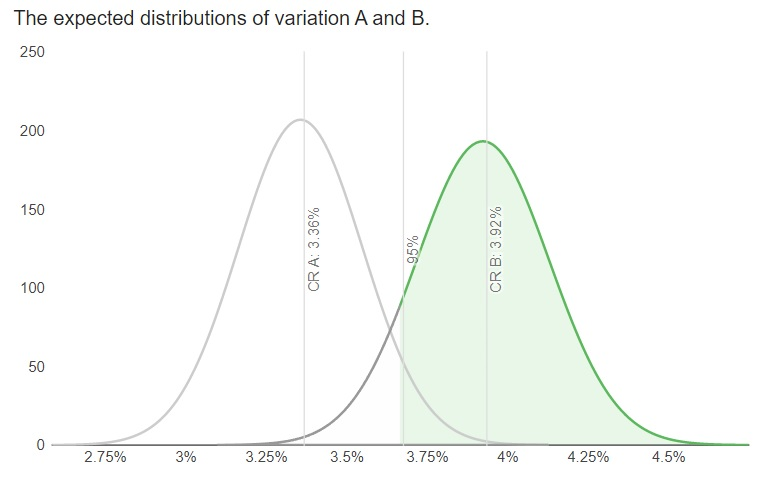

In [21]:
from IPython.display import Image
Image('C:/Users/79057/OneDrive/Документы/SF/IDE/distribution.jpg')

Распределение похоже на нормальное. Поэтому для проверки гипотезы о равенстве конверсий применим Z-тест.

H-0: конверсии обеих групп равны;

H-1: конверсия в тестовой группе выше.

В результате, *p-value* оказалось равно 0,022. Это меньше, чем критический уровень статистической значимости (0,05). Значит мы можем отвергнуть нулевую гипотезу о равенстве конверсий в обеих группах.

#### Вывод: вариант с рекомендациями показал статистически значимо лучший результат, нужно реализовывать его для всех клиентов.